# Notebook Setup

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    # MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/root/co2-flux-hourly-gpp-modeling"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Modules

In [3]:
if IN_COLLAB:
  !pip install torch pytorch-lightning pytorch_forecasting azure-storage-blob -q

In [4]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     os.environ["MY_HOME_ABS_PATH"] = MY_HOME_ABS_PATH
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# Load data from Azure blob

## Define Local File System Constants

In [5]:
root_dir  = MY_HOME_ABS_PATH
tmp_dir   = root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
PREPRO_DIR = root_dir + "/code/src/preprocessing/preproc_objects"

container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

# Load data from blob

In [9]:
target_variable = 'GPP_NT_VUT_REF'

non_encoded_cat_flag = ['month', 'day', 'hour']
categorical_cols = ['koppen_sub', 'koppen_main', 'MODIS_PFT', 'MODIS_IGBP', 'MODIS_LC']
realNum_cols = ['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 
                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
                'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai',
                'LST_Day', 'LST_Night']

features = non_encoded_cat_flag + categorical_cols + realNum_cols
supplement_cols= ['site_id', 'timestep_idx_local','gap_flag_hour','gap_flag_month',]

In [11]:
data_df = get_raw_datasets(container, blob_name)
data_df = data_df.loc[data_df['timestep_idx_local'] < 24*180, ].copy() # TODO: remove
data_df = data_df[[target_variable] + features + supplement_cols]
print(f"\nData size: {data_df.shape}")

# Set data type
data_df[non_encoded_cat_flag] = data_df[non_encoded_cat_flag].apply(pd.to_numeric)

# Drop gap flag hour = 1
data_df[data_df["gap_flag_hour"] == float(0)].reset_index(drop=True)
print(f"\nDrop gap-filled (hour) - Data size: {data_df.shape}")

# Dummy encoder categorical variables
dummy_df = pd.get_dummies(data_df[categorical_cols])
data_df = data_df.drop(columns=categorical_cols)
data_df = pd.concat([data_df, dummy_df], axis=1)
print(f"\nData size: {data_df.shape}")
print(data_df.columns)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0

Data size: (557280, 42)

Drop gap-filled (hour) - Data size: (557280, 42)

Data size: (557280, 78)
Index(['GPP_NT_VUT_REF', 'month', 'day', 'hour', 'TA_ERA', 'SW_IN_ERA',
       'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1',
       'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS

# Helper Functions


In [31]:
class X_y_set:
  X = None
  y = None

def normalize_real_cols(foldNo, realNum_cols, train_X, val_X, test_X = None):

    # Normalize data
    print(f"Normalizing real features ({len(realNum_cols)})")
    scaler = StandardScaler().fit(train_X[realNum_cols])
    train_X.loc[:,realNum_cols] = scaler.transform(train_X[realNum_cols])
    val_X.loc[:,realNum_cols] = scaler.transform(val_df[realNum_cols])

    # Save scaler object
    scaler_path = os.path.join(PREPRO_DIR, f'scaler_cv{foldNo}.joblib')
    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to {scaler_path}.")
      
    train_X.reset_index(inplace=True, drop=True)
    val_X.reset_index(inplace=True, drop=True)
    print(f"Train data size: {train_X.shape}.")
    print(f"Val data size: {val_X.shape}.")

    if test_X is not None:
      test_X.loc[:,realNum_cols] = scaler.transform(test_X[realNum_cols]) 
      test_X.reset_index(inplace=True, drop=True)
      print(f"Test data size: {test_X.shape}.") 
  
    return train_X, val_X, test_X

def split_to_X_y(df):
    dataset = X_y_set()
    dataset.X = df.drop([target_variable] + supplement_cols, axis=1)
    dataset.y = df[target_variable]                
    return dataset

def RunXGBoostCV(params, fold_data, exp_dir, debug=False):
  cv_results_df = pd.DataFrame(columns=['Fold_No', 'RMSE', 'MAE', 'R2', 'LOSS_SD', 'filename'])
  for i, cv in enumerate(fold_data):
    verbose = 0
    if debug:
      print(f"Fold {i+1}:")
      verbose = 1

    train = cv['train']
    val = cv['val']
    model = XGBRegressor(**best_params, random_state=42, n_jobs=-1, verbosity=verbose)
    model.fit(train.X, train.y)

    # Evaluate model
    val_actuals = val.y
    val_pred = model.predict(val.X)
    rmse = np.sqrt(mean_squared_error(val_actuals, val_pred))
    mae = mean_absolute_error(val_actuals, val_pred)
    r2 = r2_score(val_actuals, val_pred)
    loss_std = np.std(val_actuals - val_pred)
    if debug:
      print(f"  Val RMSE: {rmse}, Val MAE: {mae}, Val R2/NSE: {r2}, val Loss SD: {loss_std}")

    # # Save models
    filesname = f"model_cv{i+1}.pkl"
    pickle.dump(model, open( exp_dir + os.sep + filesname, 'wb'))
    print(f"  save model to {exp_dir + os.sep + filesname}.")
    result = {'Fold_No': int(i+1), 'RMSE':rmse, 'MAE':mae, 'R2':r2 , 'LOSS_SD':loss_std, 'filename': filesname}
    cv_results_df = cv_results_df.append(result, ignore_index=True)

  print(f"Results from params {best_params}:") 
  display(cv_results_df)
  display(cv_results_df[['RMSE', 'MAE', 'R2']].mean(axis=0))

  # Save CV result of CSV
  cv_results_df.to_csv(exp_dir + os.sep + "cv_result.csv", index=False)
  print(f"CV results saved to {exp_dir + os.sep + 'cv_result.csv'}")


In [13]:
def feature_importance(model, model_name, columns, fig_num, fig, ax):
  # get the feature importances
  importances = pd.Series(model.feature_importances_, index=columns)#.sort_values(ascending=False)
  # Visualize
  importances_sorted = importances.sort_values(ascending=True)[-30:]

  ax[fig_num].barh(importances_sorted.index, importances_sorted.values)
  ax[fig_num].set_title(model_name + '  Feature Importances')
  ax[fig_num].set_xlabel('Importance')
  ax[fig_num].set_ylabel('Feature')
  return importances

# Create CV dataset

In [14]:
TEST_INDEX = 4
fold_data = []
for i in range(4):
  print(f"\nFold {i+1}:")
  train_df, val_df, _ = get_splited_datasets(data_df, i, TEST_INDEX)
  
  train = split_to_X_y(train_df)
  val   = split_to_X_y(val_df)
  train.X, val.X, _ = normalize_real_cols(int(i+1), realNum_cols, train.X, val.X, None)
  
  print(f"  train_y({train.y.shape}), train_X({train.X.shape})")
  print(f"  val_y({val.y.shape}), val_X({val.X.shape})")
  fold_data.append({"train": train, "val": val})


Fold 1:
Normalizing real features (29)
Saved scaler to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_cv1.joblib.
Train data size: (336960, 73).
Val data size: (112320, 73).
  train_y((336960,)), train_X((336960, 73))
  val_y((112320,)), val_X((112320, 73))

Fold 2:
Normalizing real features (29)
Saved scaler to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_cv2.joblib.
Train data size: (336960, 73).
Val data size: (112320, 73).
  train_y((336960,)), train_X((336960, 73))
  val_y((112320,)), val_X((112320, 73))

Fold 3:
Normalizing real features (29)
Saved scaler to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_cv3.joblib.
Train data size: (336960, 73).
Val data size: (112320, 73).
  train_y((336960,)), train_X((336960, 73))
  val_y((112320,)), val_X((112320, 73))

Fold 4:
Normalizing real features (29)
Saved scaler to

# Cross Validation with Default XGBoost Params

In [15]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(xgboost.__version__)
import random
from pprint import pprint

1.7.5


In [32]:
# Create model result directory
#experiment_ts = datetime.now().strftime("%y%m%d_%H%M")
experiment_ts = "tmp"
exp_dir = model_dir + os.sep + f"xgboost_{experiment_ts}" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")
  
best_params = {}
best_params['n_estimators'] = 5
best_params['max_depth'] = 3
cv_results = RunXGBoostCV(best_params, fold_data, exp_dir)

Experiment logs saved to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp.
  save model to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp/model_cv1.pkl.
  save model to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp/model_cv2.pkl.
  save model to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp/model_cv3.pkl.
  save model to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp/model_cv4.pkl.
Results from params {'n_estimators': 5, 'max_depth': 3}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,4.07137,2.20834,0.60802,4.01710,model_cv1.pkl
1,2,3.48315,1.95878,0.67396,3.48289,model_cv2.pkl
2,3,4.47469,2.36585,0.61033,4.41098,model_cv3.pkl
3,4,4.15057,2.32127,0.67554,4.13708,model_cv4.pkl


RMSE   4.04494
MAE    2.21356
R2     0.64196
dtype: float64

CV results saved to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp/cv_result.csv


In [ ]:
# SAMPLE FOR RANDOME Search
# Create model result directory
experiment_ts = datetime.now().strftime("%y%m%d_%H%M")
exp_root_dir = model_dir + os.sep + f"xgboost_{experiment_ts}" 
if not (os.path.exists(exp_root_dir)):
    os.makedirs(exp_root_dir)
print(f"Experiment logs saved to {exp_root_dir}.")

# Run Randome Search
n = 10
for i in range(n):
  
  # create model dir
  exp_dir = exp_root_dir + os.sep + f"exp_{i+1}"
  if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
  print(f"\nExperiment {i+1} saved to {exp_dir}.")

  best_params = {}
  best_params['n_estimators'] = 10*random.randint(0, 5)
  best_params['max_depth'] = 5*random.randint(0, 3)
  RunXGBoostCV(best_params, exp_dir)

# Compare Feature Importances

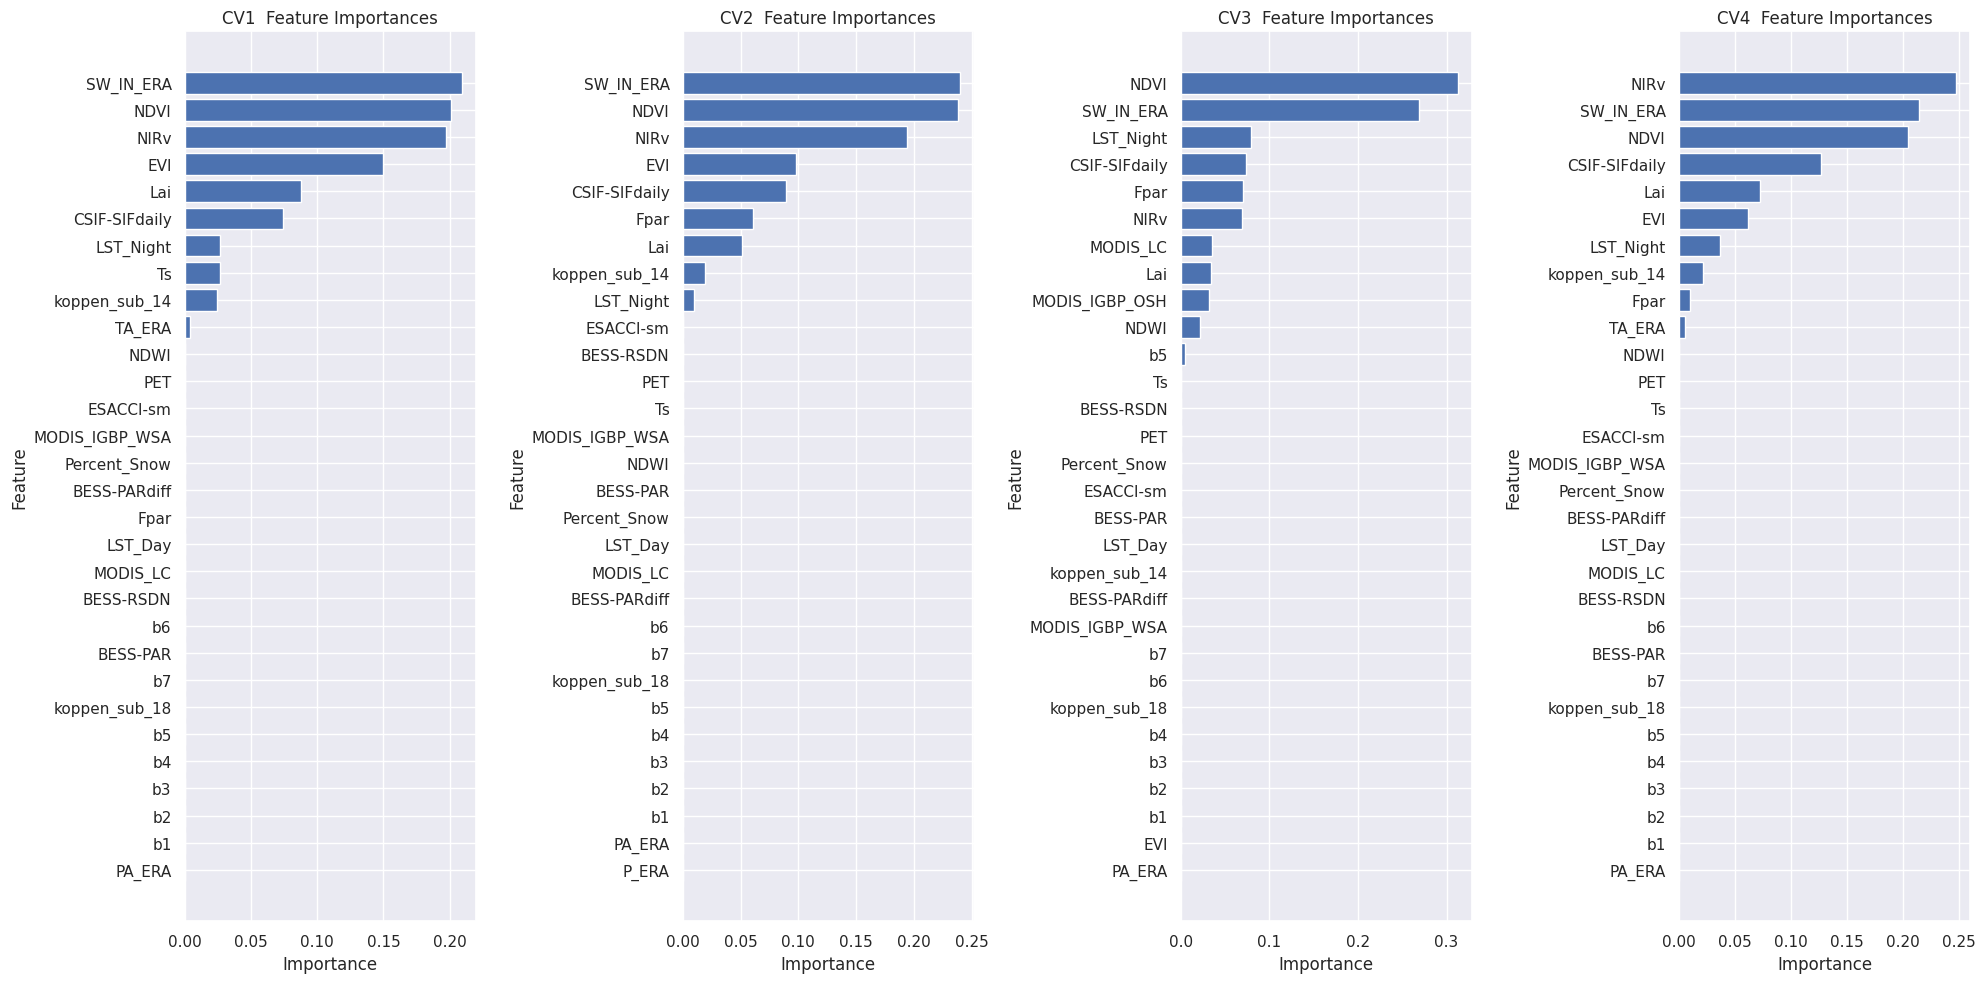

CV importance saved to /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/data/models/xgboost_tmp/cv_importance.csv


In [33]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,10), })
fig, ax = plt.subplots(1, 4, figsize=(20,10))

# Get CV result
exp_dir = root_dir + "/data/models/xgboost_tmp"
cv_results_df = pd.read_csv(exp_dir + os.sep + "cv_result.csv")

cv_importances_df = pd.DataFrame()
for i, cv in cv_results_df.iterrows():
    modelpath = exp_dir + os.sep + cv.filename
    model = pickle.load(open(modelpath, 'rb'))
    cv_importances = feature_importance(model, f"CV{cv.Fold_No}", model.feature_names_in_, i, fig, ax)
    cv_importances_df[f"cv{cv.Fold_No}"] = cv_importances

fig.tight_layout()
plt.show()
cv_importances_df = cv_importances_df.reset_index()
cv_importances_df.columns = ['feature_name','cv1', 'cv2', 'cv3', 'cv4']

# Save CV Importance of CSV
cv_importances_df.to_csv(exp_dir + os.sep + "cv_importance.csv", index=False)
print(f"CV importance saved to {exp_dir + os.sep + 'cv_importance.csv'}")

In [90]:
cv_importances_df

,feature_name,cv1,cv2,cv3,cv4
0,TA_ERA,0.00408,0.00000,0.00000,0.00527
1,SW_IN_ERA,0.20922,0.23997,0.26875,0.21411
2,LW_IN_ERA,0.00000,0.00000,0.00000,0.00000
3,VPD_ERA,0.00000,0.00000,0.00000,0.00000
4,P_ERA,0.00000,0.00000,0.00000,0.00000
5,PA_ERA,0.00000,0.00000,0.00000,0.00000
6,EVI,0.14965,0.09810,0.00000,0.06178
7,NDVI,0.20092,0.23832,0.31295,0.20437
8,NIRv,0.19696,0.19384,0.06900,0.24754
9,b1,0.00000,0.00000,0.00000,0.00000


## Look at the distribution of loss

Text(0.5, 1.0, 'Loss_Group4')

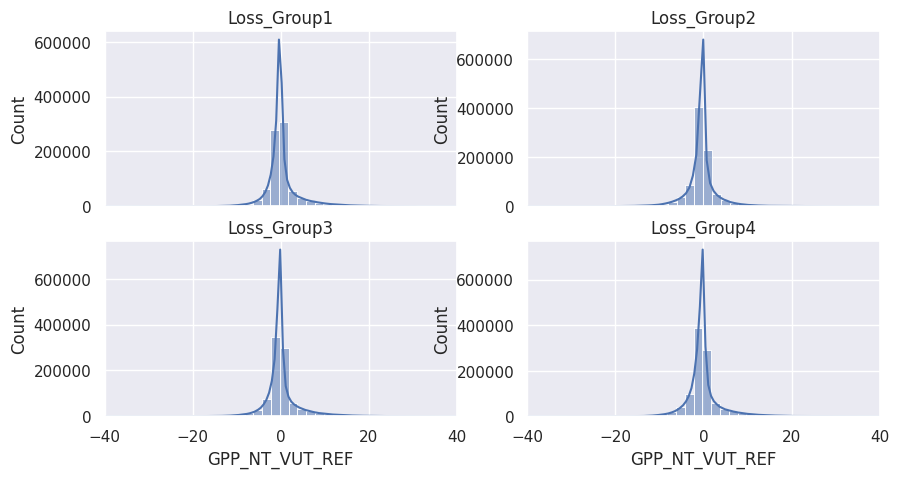

In [ ]:
import seaborn as sns
sns.set()
# fig, axes = plt.subplots(figsize=(20,10))
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,5))
plt.xlim([-40, 40])


# sns.histplot(loss1, binwidth=3, kde=True) #ax=axes(0,0), 
sns.histplot(ax=axes[0,0], data=loss1, binwidth=2, kde=True)
axes[0,0].set_title("Loss_Group1")
sns.histplot(ax=axes[0,1], data=loss2, binwidth=2, kde=True)
axes[0,1].set_title("Loss_Group2")
sns.histplot(ax=axes[1,0], data=loss3, binwidth=2,kde=True)
axes[1,0].set_title("Loss_Group3")
sns.histplot(ax=axes[1,1], data=loss4, binwidth=2, kde=True)
axes[1,1].set_title("Loss_Group4")


Text(0.5, 1.0, 'CDF of loss by group')

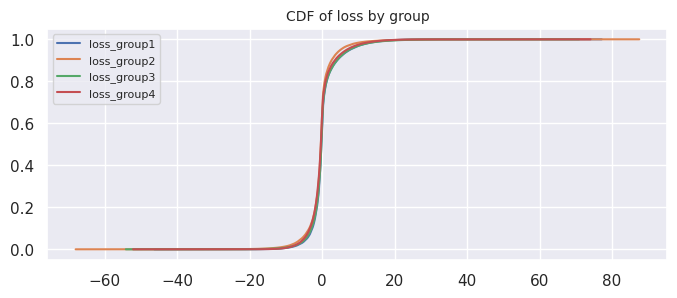

In [ ]:
fig, axes = plt.subplots(figsize=(8,3))



count, bins_count = np.histogram(loss1, bins=len(loss1))
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="loss_group1")

count, bins_count = np.histogram(loss2, bins=len(loss2))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="loss_group2")

count, bins_count = np.histogram(loss3, bins=len(loss3))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="loss_group3")

count, bins_count = np.histogram(loss4, bins=len(loss4))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="loss_group4")

plt.legend(fontsize=8)
plt.title("CDF of loss by group", fontsize=10)

In [ ]:
len(cv_importances_df['feature_name'])

57

# Dimensionality Reduction + CV

In [ ]:
def RFR_fit_show_result(model, X_train, y_train, X_val, y_val, feature_list, model_name, feature_type):
  X_train = X_train[feature_list]
  y_train = y_train
  X_val = X_val[feature_list]
  y_val = y_val
  
  model.fit(X_train, y_train)
  # Predict on val/test sets
  y_pred_val = model.predict(X_val)
  # y_pred_test = model.predict(X_test)

  # Evaluate predictions - VAL
  rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
  mae = mean_absolute_error(y_val, y_pred_val)
  r2 = r2_score(y_val, y_pred_val)
  print(f"   ")
  print(f"{model_name}, Val RMSE: {rmse}, Val MAE: {mae}, Val R2/NSE: {r2}")
  return [model_name, feature_type, feature_list, rmse, mae, r2]

In [ ]:

# cv_importances_df = cv_importances_df.drop(["Unnamed: 0"], axis=1)
# how many features when they reach 80% of importance
cv1_sort = list(cv_importances_df["cv1"])
cv1_sort.sort(reverse=True)
cv2_sort = list(cv_importances_df["cv2"])
cv2_sort.sort(reverse=True)
cv3_sort = list(cv_importances_df["cv3"])
cv3_sort.sort(reverse=True)
cv4_sort = list(cv_importances_df["cv4"])
cv4_sort.sort(reverse=True)

print(sum(cv1_sort[:8]))
print(sum(cv2_sort[:8]))
print(sum(cv3_sort[:8]))
print(sum(cv4_sort[:8]))

0.7888743609694847
0.8140367485436413
0.7918502836441264
0.7921367887210976


In [ ]:
# SW, hour, Lai, NIRv, EVI, TA, VPD, NDVI, CSIF-SIF, 
# Fpar, b1, BESS PAR, 

tier1 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai']
tier2 = ['TA_ERA','VPD_ERA','EVI','CSIF-SIFdaily']
tier3 = ['Fpar','b1','BESS-PAR']

In [ ]:
model_1, model_2, model_3 = [],[],[]

feature_list = [tier1 + tier2 + tier3, tier1 + tier2, tier1]
feature_list

[['SW_IN_ERA',
  'NDVI',
  'NIRv',
  'hour',
  'Lai',
  'TA_ERA',
  'SW_IN_ERA',
  'VPD_ERA',
  'EVI',
  'NDVI',
  'NIRv',
  'hour',
  'Lai',
  'CSIF-SIFdaily',
  'Fpar',
  'b1',
  'BESS-PAR'],
 ['SW_IN_ERA',
  'NDVI',
  'NIRv',
  'hour',
  'Lai',
  'TA_ERA',
  'SW_IN_ERA',
  'VPD_ERA',
  'EVI',
  'NDVI',
  'NIRv',
  'hour',
  'Lai',
  'CSIF-SIFdaily'],
 ['SW_IN_ERA', 'NDVI', 'NIRv', 'hour', 'Lai']]

In [ ]:
result = [["cv_group","feature_list", "feature_list", "RMSE", "MAE", "R2"]]
cv_group_list = ["cv_group1", "cv_group2", "cv_group3", "cv_group4"]
feature_type = ["tier1-3", "tier1-2", "tier1"]

dataset = [[X_train_cv1, y_train_cv1, X_val_cv1, y_val_cv1],
           [X_train_cv2, y_train_cv2, X_val_cv2, y_val_cv2],
           [X_train_cv3, y_train_cv3, X_val_cv3, y_val_cv3],
           [X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4]]#, X_test_cv3, y_test_cv3

for idx_f, features in enumerate(feature_list):
  for idx_d, data in enumerate(dataset):
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
    result += [RFR_fit_show_result(model, data[0], data[1], data[2], data[3], 
                                     feature_list[idx_f], cv_group_list[idx_d],
                                     feature_type[idx_f])]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group1, Val RMSE: 3.691976454327135, Val MAE: 1.9853894414491395, Val R2/NSE: 0.7260337606435401


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group2, Val RMSE: 3.948931201480381, Val MAE: 2.023342683193204, Val R2/NSE: 0.6511000123707802


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group3, Val RMSE: 3.9088792899138145, Val MAE: 2.085646285945488, Val R2/NSE: 0.7182069433465055


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.593481307762386, Val MAE: 2.001562948256311, Val R2/NSE: 0.757484885866779


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished


   
cv_group1, Val RMSE: 3.69387373914418, Val MAE: 1.9859456248096448, Val R2/NSE: 0.7257521090394433


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group2, Val RMSE: 3.954062269611647, Val MAE: 2.028984911521879, Val R2/NSE: 0.6501927326087031


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group3, Val RMSE: 3.8994384982534296, Val MAE: 2.082501667191697, Val R2/NSE: 0.7195664823250388


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.587011052127203, Val MAE: 1.9967780673656663, Val R2/NSE: 0.7583574225485891


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.7155620048262668, Val MAE: 2.0055873133520676, Val R2/NSE: 0.7225222083892042


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9918121428650246, Val MAE: 2.059085831424114, Val R2/NSE: 0.6434815506569835


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.93434505619453, Val MAE: 2.1129904105418444, Val R2/NSE: 0.7145233035511777


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group4, Val RMSE: 3.6281908730066212, Val MAE: 2.027997757504865, Val R2/NSE: 0.7527773355138901


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
dimensionality_reduction_RFR_df_2 = pd.DataFrame(result[1:], columns=result[0])
dimensionality_reduction_RFR_df_2

,cv_group,feature_list,feature_list,RMSE,MAE,R2
0,cv_group1,tier1-3,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.69198,1.98539,0.72603
1,cv_group2,tier1-3,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.94893,2.02334,0.65110
2,cv_group3,tier1-3,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.90888,2.08565,0.71821
3,cv_group4,tier1-3,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.59348,2.00156,0.75748
4,cv_group1,tier1-2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.69387,1.98595,0.72575
5,cv_group2,tier1-2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.95406,2.02898,0.65019
6,cv_group3,tier1-2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.89944,2.08250,0.71957
7,cv_group4,tier1-2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, SW_...",3.58701,1.99678,0.75836
8,cv_group1,tier1,"[SW_IN_ERA, NDVI, NIRv, hour, Lai]",3.71556,2.00559,0.72252
9,cv_group2,tier1,"[SW_IN_ERA, NDVI, NIRv, hour, Lai]",3.99181,2.05909,0.64348


In [ ]:
dimensionality_reduction_RFR_df_2.columns = ['cv_group', 'feature_cat', 'feature_list', 'RMSE', 'MAE', 'R2']

In [ ]:
dimensionality_reduction_RFR_df_2.groupby(by=["feature_cat"]).mean()

,RMSE,MAE,R2
feature_cat,,,
tier1,3.81748,2.05142,0.70833
tier1-2,3.78360,2.02355,0.71347
tier1-3,3.78582,2.02399,0.71321


In [ ]:
f1 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA']
f2 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','EVI']
f3 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','VPD_ERA']
f4 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','Fpar','b1','BESS-PAR']  
  
# ['Fpar','b1','BESS-PAR']

feature_list = [f1,f2,f3,f4]

In [ ]:
result = [["cv_group","feature_list", "feature_list", "RMSE", "MAE", "R2"]]
cv_group_list = ["cv_group1", "cv_group2", "cv_group3", "cv_group4"]
feature_type = ["f1", "f2", "f3","f4"]

dataset = [[X_train_cv1, y_train_cv1, X_val_cv1, y_val_cv1],
           [X_train_cv2, y_train_cv2, X_val_cv2, y_val_cv2],
           [X_train_cv3, y_train_cv3, X_val_cv3, y_val_cv3],
           [X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4]]#, X_test_cv3, y_test_cv3

for idx_f, features in enumerate(feature_list):
  for idx_d, data in enumerate(dataset):
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
    result += [RFR_fit_show_result(model, data[0], data[1], data[2], data[3], 
                                     feature_list[idx_f], cv_group_list[idx_d],
                                     feature_type[idx_f])]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.7121977761200764, Val MAE: 1.998608405486447, Val R2/NSE: 0.7230244614189282


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9596221515788024, Val MAE: 2.0321755207599366, Val R2/NSE: 0.6492082997107986


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.900639915926035, Val MAE: 2.0887120453232972, Val R2/NSE: 0.719393652474541


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.601425641209543, Val MAE: 1.9980914788048865, Val R2/NSE: 0.7564114139780759


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.7402009787659938, Val MAE: 2.015404781531328, Val R2/NSE: 0.7188299344517914


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9816942490337954, Val MAE: 2.0581061588333736, Val R2/NSE: 0.6452865676038153


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.9431619715105626, Val MAE: 2.1180290644136077, Val R2/NSE: 0.7132423563226556


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.619585237929429, Val MAE: 2.0223469811575794, Val R2/NSE: 0.7539487099042566


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.707144640202475, Val MAE: 1.997089642786963, Val R2/NSE: 0.7237780001821438


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9735746321983334, Val MAE: 2.0450542818183237, Val R2/NSE: 0.6467317817949978


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.926336420505469, Val MAE: 2.102512380320124, Val R2/NSE: 0.7156843363972326


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.6338948014285513, Val MAE: 2.0286810463244427, Val R2/NSE: 0.7519994002384977


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished


   
cv_group1, Val RMSE: 3.7307366330390663, Val MAE: 2.0176883128354497, Val R2/NSE: 0.7202511007801866


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished


   
cv_group2, Val RMSE: 3.9684222975388774, Val MAE: 2.0475740898144865, Val R2/NSE: 0.6476473181574016


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished


   
cv_group3, Val RMSE: 3.9562667577714903, Val MAE: 2.1228154119517155, Val R2/NSE: 0.7113331564502048


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group4, Val RMSE: 3.6403977640053085, Val MAE: 2.0376434270340344, Val R2/NSE: 0.751110997172765


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
dimensionality_reduction_RFR_df_3 = pd.DataFrame(result[1:], columns=result[0])
dimensionality_reduction_RFR_df_3.columns = ['cv_group', 'feature_cat', 'feature_list', 'RMSE', 'MAE', 'R2']
dimensionality_reduction_RFR_df_3

,cv_group,feature_cat,feature_list,RMSE,MAE,R2
0,cv_group1,f1,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA]",3.71220,1.99861,0.72302
1,cv_group2,f1,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA]",3.95962,2.03218,0.64921
2,cv_group3,f1,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA]",3.90064,2.08871,0.71939
3,cv_group4,f1,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA]",3.60143,1.99809,0.75641
4,cv_group1,f2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, EVI]",3.74020,2.01540,0.71883
5,cv_group2,f2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, EVI]",3.98169,2.05811,0.64529
6,cv_group3,f2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, EVI]",3.94316,2.11803,0.71324
7,cv_group4,f2,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, EVI]",3.61959,2.02235,0.75395
8,cv_group1,f3,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, VPD_ERA]",3.70714,1.99709,0.72378
9,cv_group2,f3,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, VPD_ERA]",3.97357,2.04505,0.64673


In [ ]:
dimensionality_reduction_RFR_df_3.groupby(by=["feature_cat"]).mean()
# f1 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA']
# f2 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','EVI']
# f3 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','VPD_ERA']
# f4 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','Fpar','b1','BESS-PAR']  

,RMSE,MAE,R2
feature_cat,,,
f1,3.79347,2.02940,0.71201
f2,3.82116,2.05347,0.70783
f3,3.81024,2.04333,0.70955
f4,3.82396,2.05643,0.70759


In [ ]:
# f5 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','EVI']
f6 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','EVI']
f7 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','EVI','VPD_ERA']
f8 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','VPD_ERA']  
  
# ['Fpar','b1','BESS-PAR']

feature_list = [f5,f6,f7,f8]

In [ ]:
result = [["cv_group","feature_list", "feature_list", "RMSE", "MAE", "R2"]]
cv_group_list = ["cv_group1", "cv_group2", "cv_group3", "cv_group4"]
feature_type = ["f5", "f6", "f7","f8"]

dataset = [[X_train_cv1, y_train_cv1, X_val_cv1, y_val_cv1],
           [X_train_cv2, y_train_cv2, X_val_cv2, y_val_cv2],
           [X_train_cv3, y_train_cv3, X_val_cv3, y_val_cv3],
           [X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4]]#, X_test_cv3, y_test_cv3

for idx_f, features in enumerate(feature_list):
  for idx_d, data in enumerate(dataset):
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
    result += [RFR_fit_show_result(model, data[0], data[1], data[2], data[3], 
                                     feature_list[idx_f], cv_group_list[idx_d],
                                     feature_type[idx_f])]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.7455502816168393, Val MAE: 2.014170042678706, Val R2/NSE: 0.7180250903210317


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.957187460585073, Val MAE: 2.038244862917563, Val R2/NSE: 0.6496395564245704


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.9090249510665576, Val MAE: 2.0942285205117073, Val R2/NSE: 0.7181859413849707


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.5903457242826717, Val MAE: 1.9960310396286423, Val R2/NSE: 0.7579079266763288


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.7455502816168393, Val MAE: 2.014170042678706, Val R2/NSE: 0.7180250903210317


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.957187460585073, Val MAE: 2.038244862917563, Val R2/NSE: 0.6496395564245704


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.9090249510665576, Val MAE: 2.0942285205117073, Val R2/NSE: 0.7181859413849707


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.5903457242826717, Val MAE: 1.9960310396286423, Val R2/NSE: 0.7579079266763288


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group1, Val RMSE: 3.7530334408311297, Val MAE: 2.019645825567395, Val R2/NSE: 0.7168972608642035


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group2, Val RMSE: 3.9491761308392364, Val MAE: 2.0391127579719903, Val R2/NSE: 0.6510567305326926


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group3, Val RMSE: 3.916693879508452, Val MAE: 2.097508543286819, Val R2/NSE: 0.7170791017687389


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.6054913672499356, Val MAE: 2.0059985481099463, Val R2/NSE: 0.755861118857306


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.707144640202475, Val MAE: 1.9970896427869629, Val R2/NSE: 0.7237780001821438


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9735746321983334, Val MAE: 2.0450542818183237, Val R2/NSE: 0.6467317817949978


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.926336420505469, Val MAE: 2.102512380320124, Val R2/NSE: 0.7156843363972326


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group4, Val RMSE: 3.6338948014285513, Val MAE: 2.0286810463244427, Val R2/NSE: 0.7519994002384977


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
dimensionality_reduction_RFR_df_4 = pd.DataFrame(result[1:], columns=result[0])
dimensionality_reduction_RFR_df_4.columns = ['cv_group', 'feature_cat', 'feature_list', 'RMSE', 'MAE', 'R2']
dimensionality_reduction_RFR_df_4

,cv_group,feature_cat,feature_list,RMSE,MAE,R2
0,cv_group1,f5,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.74555,2.01417,0.71803
1,cv_group2,f5,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.95719,2.03824,0.64964
2,cv_group3,f5,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.90902,2.09423,0.71819
3,cv_group4,f5,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.59035,1.99603,0.75791
4,cv_group1,f6,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.74555,2.01417,0.71803
5,cv_group2,f6,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.95719,2.03824,0.64964
6,cv_group3,f6,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.90902,2.09423,0.71819
7,cv_group4,f6,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI]",3.59035,1.99603,0.75791
8,cv_group1,f7,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI...",3.75303,2.01965,0.71690
9,cv_group2,f7,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, EVI...",3.94918,2.03911,0.65106


In [ ]:
dimensionality_reduction_RFR_df_4.groupby(by=["feature_cat"]).mean()

,RMSE,MAE,R2
feature_cat,,,
f5,3.80053,2.03567,0.71094
f6,3.80053,2.03567,0.71094
f7,3.80610,2.04057,0.71022
f8,3.81024,2.04333,0.70955


In [ ]:
f9 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','Fpar']
f10 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','b1']
f11 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','BESS-PAR']
f12 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai','TA_ERA','LW_IN_ERA']  

#remove 
#'VPD_ERA''EVI'
# ['Fpar','b1','BESS-PAR']

feature_list = [f9,f10,f11,f12]

In [ ]:
result = [["cv_group","feature_list", "feature_list", "RMSE", "MAE", "R2"]]
cv_group_list = ["cv_group1", "cv_group2", "cv_group3", "cv_group4"]
feature_type = ["f9", "f10", "f11","f12"]

dataset = [[X_train_cv1, y_train_cv1, X_val_cv1, y_val_cv1],
           [X_train_cv2, y_train_cv2, X_val_cv2, y_val_cv2],
           [X_train_cv3, y_train_cv3, X_val_cv3, y_val_cv3],
           [X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4]]#, X_test_cv3, y_test_cv3

for idx_f, features in enumerate(feature_list):
  for idx_d, data in enumerate(dataset):
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
    result += [RFR_fit_show_result(model, data[0], data[1], data[2], data[3], 
                                     feature_list[idx_f], cv_group_list[idx_d],
                                     feature_type[idx_f])]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.731869629558213, Val MAE: 2.010849506015809, Val R2/NSE: 0.7200811597264059


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9855364684090047, Val MAE: 2.0483198579636586, Val R2/NSE: 0.6446016609734068


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.906299855966533, Val MAE: 2.093423395388603, Val R2/NSE: 0.7185787259963246


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.601746316169861, Val MAE: 2.0014827840209874, Val R2/NSE: 0.7563680332474639


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.6956866761295357, Val MAE: 1.9920746068257007, Val R2/NSE: 0.7254828436610641


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9614235261571262, Val MAE: 2.037475326396006, Val R2/NSE: 0.6488890515776868


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.924824882860522, Val MAE: 2.1038901253074105, Val R2/NSE: 0.7159032025668777


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
cv_group4, Val RMSE: 3.6092941095348063, Val MAE: 2.004009073744261, Val R2/NSE: 0.7553458565830098


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.72083138370624, Val MAE: 2.004109683410557, Val R2/NSE: 0.7217346169523722


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.9424542472218485, Val MAE: 2.02006796053712, Val R2/NSE: 0.652243590670609


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.9035807443051005, Val MAE: 2.0929538340045926, Val R2/NSE: 0.7189703751625316


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group4, Val RMSE: 3.594313288097409, Val MAE: 1.9949415735057565, Val R2/NSE: 0.7573725763007865


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group1, Val RMSE: 3.7287577600377593, Val MAE: 2.007288889850102, Val R2/NSE: 0.7205477932461166


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group2, Val RMSE: 3.960956740869972, Val MAE: 2.034475249684261, Val R2/NSE: 0.6489717914149178


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group3, Val RMSE: 3.895940173140894, Val MAE: 2.0866857608270424, Val R2/NSE: 0.7200694304040224


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


   
cv_group4, Val RMSE: 3.599622114615819, Val MAE: 1.9976501743661585, Val R2/NSE: 0.756655322105208


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
dimensionality_reduction_RFR_df_5 = pd.DataFrame(result[1:], columns=result[0])
dimensionality_reduction_RFR_df_5.columns = ['cv_group', 'feature_cat', 'feature_list', 'RMSE', 'MAE', 'R2']
dimensionality_reduction_RFR_df_5

,cv_group,feature_cat,feature_list,RMSE,MAE,R2
0,cv_group1,f9,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, Fpar]",3.73187,2.01085,0.72008
1,cv_group2,f9,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, Fpar]",3.98554,2.04832,0.64460
2,cv_group3,f9,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, Fpar]",3.90630,2.09342,0.71858
3,cv_group4,f9,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, Fpar]",3.60175,2.00148,0.75637
4,cv_group1,f10,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, b1]",3.69569,1.99207,0.72548
5,cv_group2,f10,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, b1]",3.96142,2.03748,0.64889
6,cv_group3,f10,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, b1]",3.92482,2.10389,0.71590
7,cv_group4,f10,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, b1]",3.60929,2.00401,0.75535
8,cv_group1,f11,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, BES...",3.72083,2.00411,0.72173
9,cv_group2,f11,"[SW_IN_ERA, NDVI, NIRv, hour, Lai, TA_ERA, BES...",3.94245,2.02007,0.65224


In [ ]:
dimensionality_reduction_RFR_df_4.groupby(by=["feature_cat"]).mean()

,RMSE,MAE,R2
feature_cat,,,
f5,3.80053,2.03567,0.71094
f6,3.80053,2.03567,0.71094
f7,3.80610,2.04057,0.71022
f8,3.81024,2.04333,0.70955


# Rerun and store the best model(=group4)

In [ ]:

tier1 = ['SW_IN_ERA','NDVI','NIRv','hour','Lai']
tier2 = ['TA_ERA','VPD_ERA','EVI','CSIF-SIFdaily']
feature_list = tier1 + tier2

In [ ]:
# our manual split group
# X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4, X_test_cv4, y_test_cv4 

In [ ]:
# def RFR_fit_show_result(
X_train, y_train, X_val, y_val  = X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4
X_train = X_train[feature_list]
y_train = y_train
X_val = X_val[feature_list]
y_val = y_val

model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)
# Predict on val/test sets
y_pred_val = model.predict(X_val)
# y_pred_test = model.predict(X_test)

# Evaluate predictions - VAL
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
print(f"Val RMSE: {rmse}, Val MAE: {mae}, Val R2/NSE: {r2}")

Val RMSE: 3.5986371234271397, Val MAE: 2.0029512628185677, Val R2/NSE: 0.7567884802876568


In [ ]:
model_objects_dir

'/content/drive/MyDrive/TFT_baseline/code/src/modeling/model_objects'

In [ ]:
# Save model object
filename = 'rfr_topX_best_April7.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_val, y_val)
print(result)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


0.7567884802876568


[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
# Re-load saved model
# try:
#     model_pkl = joblib.load(model_save_path_pkl)
#     model_jl = joblib.load(model_save_path_jl)
#     print("Loaded both model objects")
# except:
#     print("unable to load models, make sure object paths are correct and conda env in use")

In [ ]:
# Load scaler objects
# scaler_v2_obj = '/root/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_rfr-mvp-v2.joblib'
# try:
#     scaler_v2 = joblib.load(scaler_v2_obj)
#     print("Loaded scaler objects")
# except:
#     print("unable to load models, make sure object paths are correct and conda env in use")

## Evaluate RFR on Val & Test Set

In [ ]:
# # Predict on val/test sets
# y_pred_val = model_pkl.predict(X_val)
# y_pred_test = model_pkl.predict(X_test)

# # Evaluate predictions - VAL
# rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
# mae = mean_absolute_error(y_val, y_pred_val)
# r2 = r2_score(y_val, y_pred_val)
# print(f"Val RMSE: {rmse}")
# print(f"Val MAE: {mae}")
# print(f"Val R2/NSE: {r2}")